In [1]:
# tiny shakespear

import neurotron
from neurotron import Cells, Train, Token, Text, Toy, Monitor, Ansi, SynapseErr
import neurotron.math as nm
isa = isinstance

In [2]:
class Trainer(Train):
    def __init__(self,cells,plot=False,verbose=0):
        super().__init__(cells,verbose=verbose,plot=plot)

    def __call__(self,context,n=None,verbose=None,plot=None):
        return super().__call__(context,n,verbose=verbose,plot=plot)
        
    def prediction(self,context):
        if context in self._contexts:
            info = self._contexts[context]
            counters = []; total = 0
            for key in info:
                if not key in ['#','@']:
                    n,refer,idx = info[key]
                    total += n
                    counters.append(n)
                    #print('    statistics: %s:' % key,(counters,total))
            result = []; k = 0
            src = self.address(context)
            for key in info:
                if not key in ['#','@']:
                    ratio = counters[k]/total
                    k += 1
                    n,refer,idx = info[key]
                    dst = self.address(refer)
                    result.append((refer,ratio,src,dst))
                    #print('    predict(%g%%): %s ->'%(100*ratio,key),info[key])
            return result

    def predict(self,context):
        results = self.prediction(context)
        for prediction in results:
            refer,ratio,src,dst = prediction
            print('    %g%%: ->' % (100*ratio),refer,src,dst)
    
    def address(self,context):
        if context in self._contexts:
            info = self._contexts[context]
            m,n,d,s = self.cells.shape
            idx = train.code((info['@'][1])).list()[0]; 
            jdx = info['#'][0]
            assert len(idx) == len(jdx)
            kdx = [jdx[s]*m+idx[s] for s in range(len(idx))]
            #return ((m,n),idx,jdx,kdx)
            return kdx
        return None

    def learn(self,context,verbose=0,plot=False):
        results = self.prediction(context)
        if results is None: return
        for prediction in results:
            refer,ratio,src,dst = prediction
            if verbose:
                print('    %4.1f%%:' % (100*ratio),context,'->',refer,src,dst)
            self.cells.init()
            for k in dst:
                self.cells.X[k] = 1
            for k in src:
                self.cells.Y[k] = 1

            self.cells.connect(src,dst)
            title = 'learn: ' + refer
            #if self.plotting: self.plot(title)
            if plot: self.plot(title)
            self.cells.init()

    def program(self,verbose=0):   # learn all contexts
        """
        learn all contexts
        >>> train = Trainer(Cells('Mary'))
        >>> train.program()
        """
        for context in self._contexts:
            results = self.prediction(context)
            for prediction in results:
                refer,ratio,src,dst = prediction
                for k in dst:
                    self.cells.X[k] = 1
                for k in src:
                    self.cells.Y[k] = 1
                try:
                    self.cells.connect(src,dst)
                    if verbose:
                        print(Ansi.G + '    learning:',context,'OK'+Ansi.N)
                except SynapseErr:
                    print(Ansi.R+'    learning:',context,'FAIL'+Ansi.N)

    def plot(self,title=''):
        m,n,d,s = self.cells.shape
        mon = Monitor(m,n)
        self.cells.plot(mon,label=True)
        mon.title(title)

    def analyse(self,sentence,all=False):
        if all:
            prediction = self.cells.process(sentence)
        else:
            prediction = self.cells.run(sentence)
            self.plot()
        return prediction
        

In [3]:
rawtext = Toy('Tiny').raw; print(rawtext[:1000])
text = Text(rawtext,8); print(text)
cells = Cells((2,8,4,3),3,verbose=0)
train = Trainer(cells,plot=False)
#for k in range(1): train(text[k])
#train.program()
#train.show()
#train.analyse(text(1),all=True)
#train.predict('<Lisa likes to>')
#train.program()

First Citizen: Before we proceed any further, hear me speak.  All: Speak, speak.  First Citizen: You are all resolved rather to die than to famish?  All: Resolved. resolved.  First Citizen: First, you know Caius Marcius is chief enemy to the people.  All: We know't, we know't.  First Citizen: Let us kill him, and we'll have corn at our own price. Is't a verdict?  All: No more talking on't; let it be done: away, away!  Second Citizen: One word, good citizens.  First Citizen: We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely; but they think we are too dear: the leanness that afflicts us, the object of our misery, is as an inventory to particularise their abundance; our sufferance is a gain to them Let us revenge this with our pikes, ere we become rakes: for the gods know I speak this in hunger for bread, not in thirst for revenge.  

In [4]:
train('F i r s t',verbose=1)
train('F i r m',2,verbose=1)


    100.0%: <F> -> <F i> [6, 8, 10] [0, 2, 14]
    100.0%: <F i> -> <F i r> [0, 2, 14] [6, 10, 14]
    100.0%: <F i r> -> <F i r s> [6, 10, 14] [0, 2, 8]
    100.0%: <F i r s> -> <F i r s t> [0, 2, 8] [8, 10, 14]
    100.0%: <F> -> <F i> [6, 8, 10] [0, 2, 14]
    100.0%: <F i> -> <F i r> [0, 2, 14] [6, 10, 14]
    50.0%: <F i r> -> <F i r s> [6, 10, 14] [0, 2, 8]
    50.0%: <F i r> -> <F i r m> [6, 10, 14] [2, 4, 12]
    100.0%: <F> -> <F i> [6, 8, 10] [0, 2, 14]
    100.0%: <F i> -> <F i r> [0, 2, 14] [6, 10, 14]
    33.3%: <F i r> -> <F i r s> [6, 10, 14] [0, 2, 8]
    66.7%: <F i r> -> <F i r m> [6, 10, 14] [2, 4, 12]


'<F i r m>'

In [5]:
cells.run('F i r')

['F', '->', 'i', 'r', ['s', 'm']]

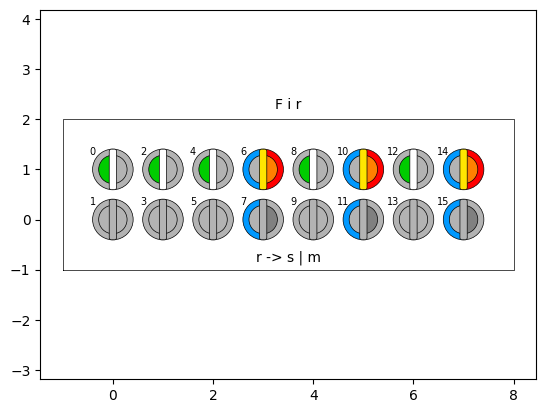

In [6]:
cells.plot('F i r')

In [7]:
toy = Toy('Tiny')
print(toy.raw[:400])
toy.text = Text(toy.raw,8);  print(toy.text)
cells = Cells((2,10,4,3),3,verbose=1)
train = Trainer(cells,verbose=0)

First Citizen: Before we proceed any further, hear me speak.  All: Speak, speak.  First Citizen: You are all resolved rather to die than to famish?  All: Resolved. resolved.  First Citizen: First, you know Caius Marcius is chief enemy to the people.  All: We know't, we know't.  First Citizen: Let us kill him, and we'll have corn at our own price. Is't a verdict?  All: No more talking on't; let it 
Text(139424,8,['First Ci','tizen: B','efore we',...])


In [8]:
# Training
## g

In [22]:
train('F i r s t')
train('F i r m',2)
train(['F','i','r','m'])
train.show()

token:
    [17, 18, 19] .: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
    [5, 11, 12] F: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
    [8, 9, 11] i: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    [0, 5, 15] r: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    [1, 12, 16] s: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
    [6, 7, 13] t: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    [5, 11, 18]  : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
    [10, 14, 18] C: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
    [4, 9, 17] z: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    [0, 9, 13] e: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    [1, 7, 9] n: [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [0, 8, 17] :: [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    [13, 15, 19] B: [0, 0, 0, 0, 0, 0, 

In [23]:
toy.text = Toy('Tiny').text;  print(toy.text)
cells = Cells((4,20,40,3),3,char=True)
train = Trainer(cells)

Text(139424,8,['First Ci','tizen: B','efore we',...])


In [24]:
N = 10
for k in range(N): print(toy.text(k))
for k in range(N): train(toy.text(k))

['F', 'i', 'r', 's', 't', ' ', 'C', 'i']
['t', 'i', 'z', 'e', 'n', ':', ' ', 'B']
['e', 'f', 'o', 'r', 'e', ' ', 'w', 'e']
[' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd']
[' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r']
['t', 'h', 'e', 'r', ',', ' ', 'h', 'e']
['a', 'r', ' ', 'm', 'e', ' ', 's', 'p']
['e', 'a', 'k', '.', ' ', ' ', 'A', 'l']
['l', ':', ' ', 'S', 'p', 'e', 'a', 'k']
[',', ' ', 's', 'p', 'e', 'a', 'k', '.']


['F', '->', 'i', 'r', 's', 't']

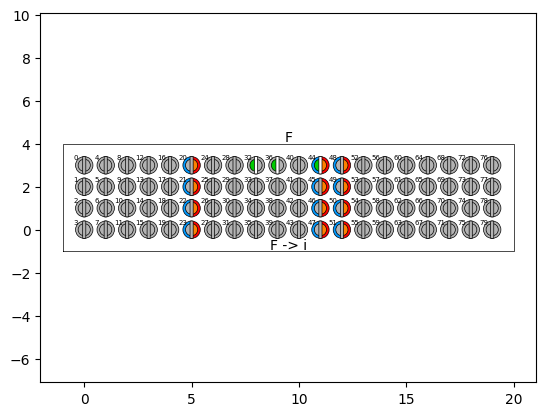

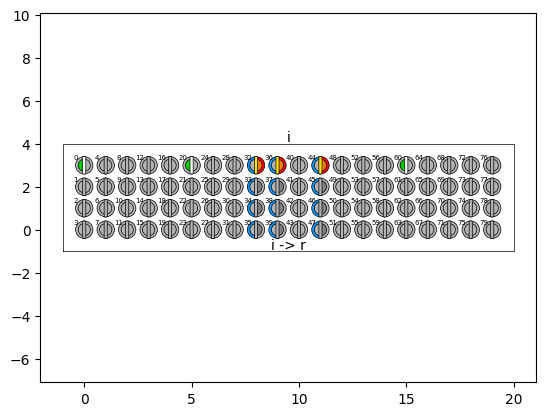

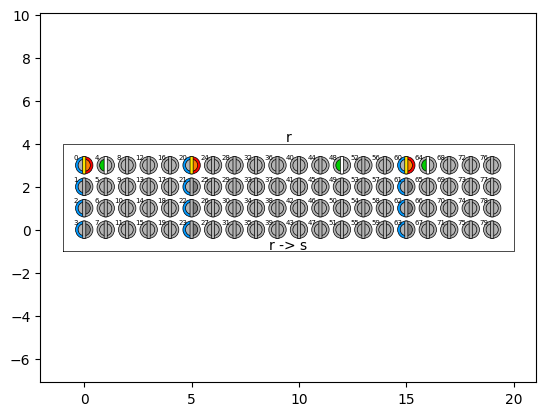

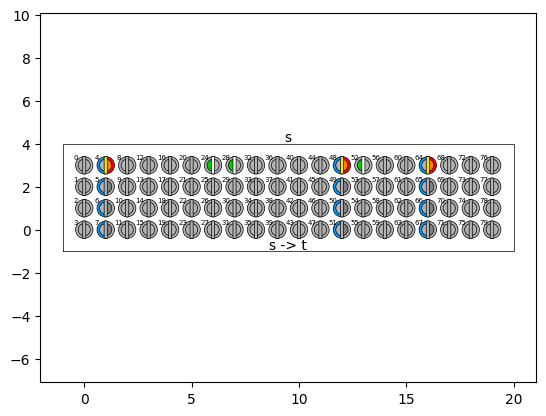

In [25]:
cells.process('Firs',plot=True)

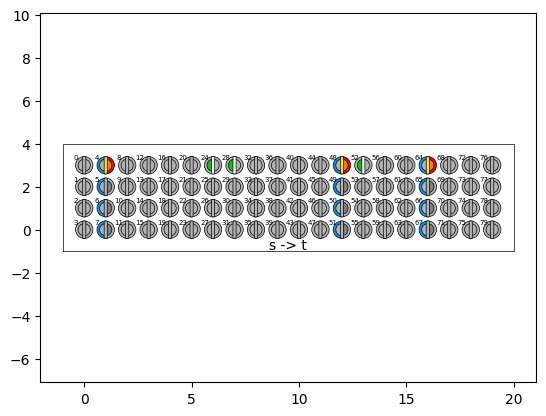

In [26]:
cells.plot()

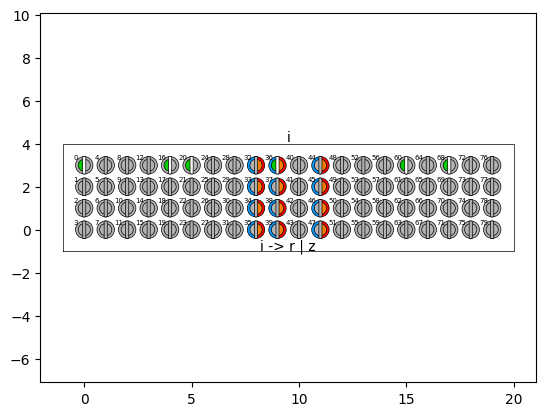

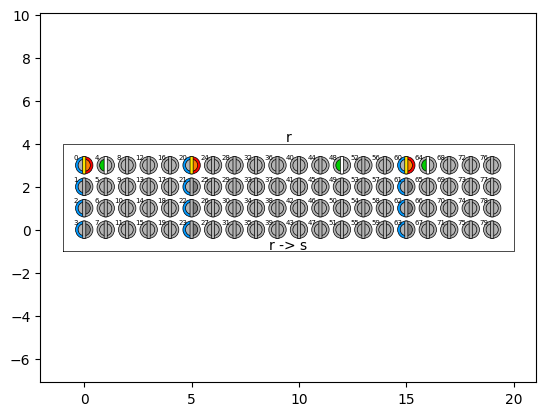

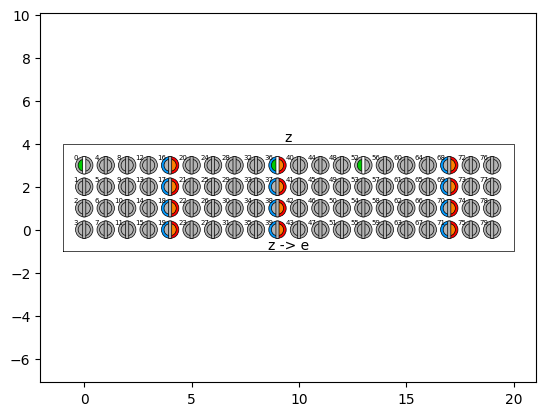

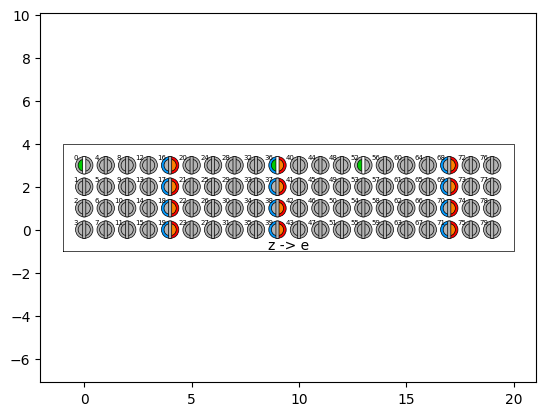

In [27]:
cells.process('irz',plot=True);cells.plot()

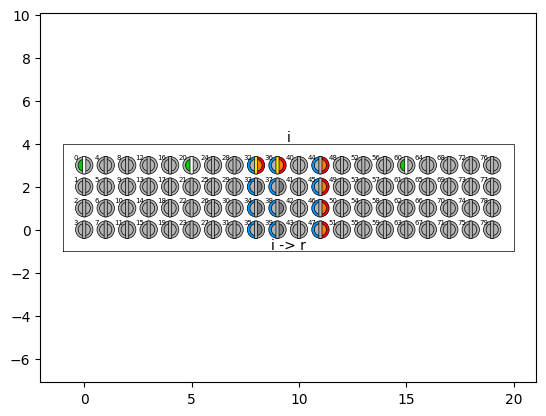

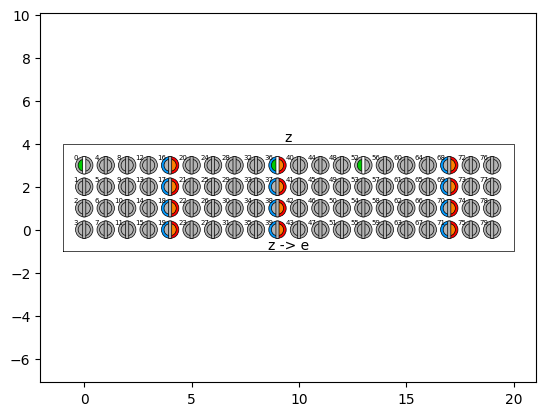

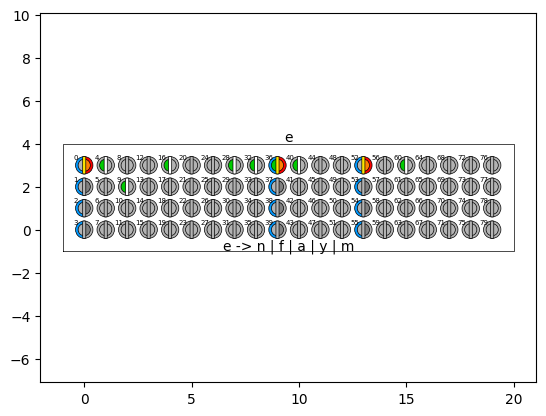

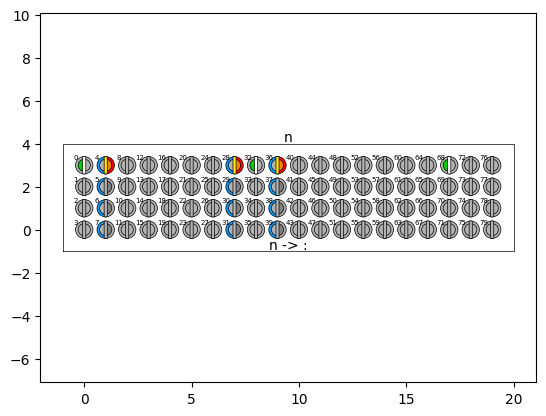

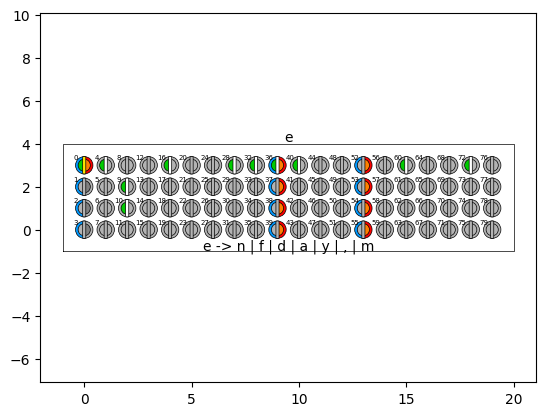

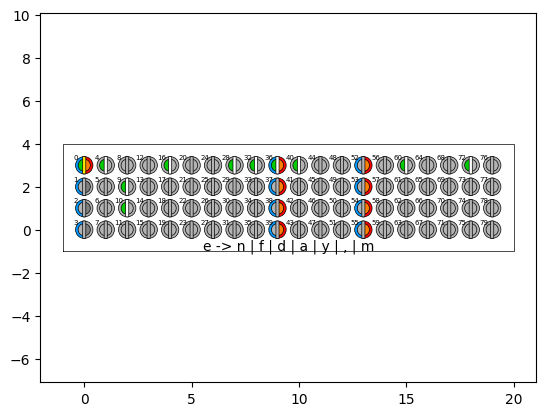

In [30]:
cells.process('izene',plot=True)
cells.plot()

In [34]:
cells.run('speak')

['s', '->', ['t', 'p'], 'e', 'a', 'k', '.']

In [39]:
cells.run('stizen')

['s', '->', 't', ['i', ' ', 'h'], 'z', 'e', ['n', 'f', 'a', 'y', 'm'], ':']